# Lorenz96
For a number of variables $ J \in \mathbb{N} $, external force $ F \in \mathbb{R} $ and state variable $ \mathbb{u} \in \mathbb{R}^J $ on 1D periodic domain, the Lorenz 96 equation (Lorenz 1996) is given by

$$ \frac {du^{i}}{dt} =(u^{i+1}-u^{i-2})u^{i-1}-u^{i}+F, $$

with $ u^{-1} = u^{J-1} $, $ u^0 = u^J $, and $ u^{J+1} = u^1 $.

## Partial observation
Let $ J = 3J' $ for $ J' \in \mathbb{N} $.

$$ P = [e_1, e_2, 0, e_4, e_5, 0, e_7, \dots, 0] \in \mathbb{R}^{J \times J}, $$

where $ (e_i)_{i=1}^J $ is a standard basis of $ \mathbb{R}^J $.

cf. K. J. H. Law, D. Sanz-Alonso, A. Shukla, and A. M. Stuart, Filter accuracy for the Lorenz 96 model: Fixed versus adaptive observation operators, Phys. Nonlinear Phenom., 325 (2016), pp. 1–13.

In [400]:
import numpy as np
import matplotlib.pyplot as plt
from da.l96 import lorenz96
from da.scheme import rk4
from da.visualize import plot_loss
from da.var3d import Var3D
data_dir = "../data"

In [401]:
# Lorenz96
# J: dim of state space
J = 60

# F: forcing
F = 8

print("(J, F):", (J, F))

(J, F): (60, 8)


## Generate the true trajectory

In [ ]:
# generate data
# dt: time step size
dt = 0.1
print("dt:", dt)

# N: number of time steps, 2 years : 20*360*2 steps
N = 1000
N0 = N//2
print("N:", N)

# initial state near the statinary point
x0 = F*np.ones(J) # the statinary point
x0[19] *= 1.001 # perturb

# use my modules
scheme = rk4
p = (F, )

try:
    x_true = np.load(f"{data_dir}/x_true_l96_full.npy")
    print("x_true loaded:", x_true.shape)
except:
    result = np.zeros((N0+N,len(x0)))
    x = x0
    result[0] = x[:]

    for n in range(1, N0+N):
        t = n*dt
        x = scheme(lorenz96, t, x, p, dt)
        result[n] = x[:]


    x_true = result[N0:] # spin up 1 year and save per 6 hours
    print("x_true.shape:", x_true.shape)
    np.save(f"{data_dir}/x_true_l96_full", x_true)

dt: 0.1
N: 1000
x_true.shape: (1000, 60)


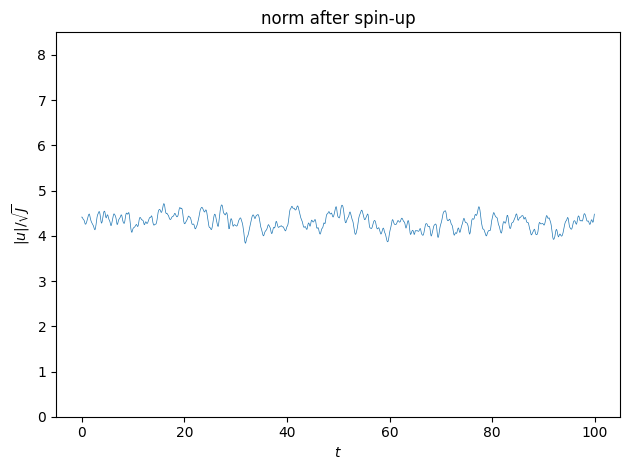

In [403]:
# norm (normalized energy)
norm = np.linalg.norm(x_true[:], axis=-1)/np.sqrt(J)
t = np.arange(N)*dt
fig3, ax3 = plt.subplots()
ax3.grid(False)
ax3.set_title('norm after spin-up')
ax3.set_xlabel('$t$')
ax3.set_ylabel('$ |u|/\\sqrt{J}$')
ax3.set_ylim([0.0, 8.5])
ax3.plot(t, norm, lw=0.5)
fig3.tight_layout()
# fig3.savefig(f"{data_dir}/l96_norm.pdf")

## DA setting

In [404]:
# observation steps
obs_per = 1
print("obs_per", obs_per, "steps")

# assimilation interval
Dt = dt * obs_per
print("assimilation interval: ", Dt)


# time array
t = np.arange(N//obs_per)*dt


# Model function for time evolution
def M(x, Dt):
    for i in range(int(Dt/dt)):
        x = rk4(lorenz96, 0, x, p, dt)
    return x

# Observation operator
# H_diag = np.ones(J) # full

H_diag = np.ones(J)
H_diag[2::3] = 0 # partial observations


H = np.diag(H_diag)
H = H[H_diag != 0] # remove zero rows
Ny = np.linalg.matrix_rank(H)
print("H.shape:", H.shape)
print("diag of H:", H_diag)
# print("rank(H):", Ny)


# Observation error covariance
r = 1e-1
R = r**2*np.eye(J)
R = H @R@H.T # project to obs space
print("obs noise std:", r)



# load true states
# Nt = (N0+N)//5//6
Nt = N
x_true = np.load(f"{data_dir}/x_true_l96_full.npy")[:Nt:obs_per]

# background error covariance
sigma = 1
B = sigma**2 * np.eye(J)
print("background error:", np.sqrt(np.trace(B)/J))

obs_per 1 steps
assimilation interval:  0.1
H.shape: (40, 60)
diag of H: [1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0.
 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0.
 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0.]
obs noise std: 0.1
background error: 1.0


In [405]:
from tqdm import tqdm

# generate observations
y = (H@x_true.T).T
y += np.random.multivariate_normal(mean=np.zeros_like(y[0]), cov=R, size=len(y))

# run da
# set DA method
var3d = Var3D(M, H, R)

# initialize ensemble
var3d.initialize(x_0=x0, B=B)
for y_obs in tqdm(y):
    var3d.forecast(Dt)
    var3d.update(y_obs)

100%|██████████| 1000/1000 [00:00<00:00, 6714.49it/s]


time-averaged RMSE: 0.10610775216897571


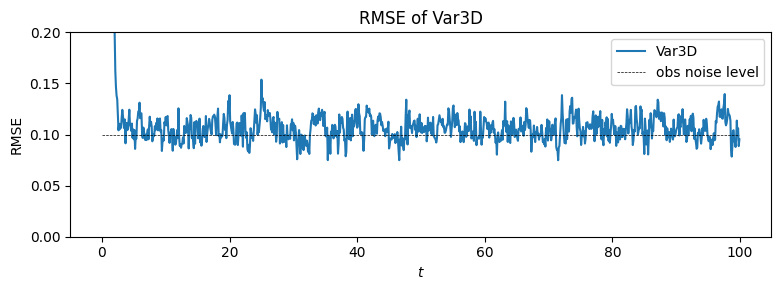

In [406]:
from da.loss import loss_rms
plot_per = obs_per
rmse = loss_rms(x_true, var3d.x)
print("time-averaged RMSE:", np.mean(rmse[N//2:]))
fig, ax = plt.subplots(figsize=(8, 3))
plt.plot(t[::plot_per], rmse[::plot_per], label='Var3D')
plt.plot(t[::plot_per], r*np.ones_like(t)[::plot_per], 'k--', lw=0.5, label='obs noise level')
plt.ylabel('RMSE')
plt.xlabel('$t$')
plt.ylim([0.0, 2 * r])
plt.title('RMSE of Var3D')
plt.legend()
plt.tight_layout()